In [5]:
# import the necessary packages
import os
import torch

# DEVICE AGNOSTIC
#### set device to 'cpu' or 'cuda' (GPU) based on availability
#### for model training and testing
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# MODEL HYPERPARAMETER
LR = 0.001             # learning rate for the model

PATIENCE = 2           # early stopping during model training where training is stopped 
                       # when performance on a validation dataset does not improve 
                       # STOP The training when result is same for 2 consecutive epochs
        
IMAGE_SIZE = 512        # defines that the size of image is 256x256
CHANNELS = 3           # defines that image's color channel is 3
BATCH_SIZE = 16        # defines that 16 training examples are used in one iteration before 
                       # updating the weight and biases of network 
    
NUM_WORKERS = os.cpu_count()     # for parallel processing
EMBEDDING_DIM = 2      # defines size of the embedding space

EPOCHS = 200            # number of complete passes through the entire training dataset
                       # i.e. model is trained on the whole dataset 10 times

    
# DATASET PATH
# CELEBFACE_ROOT = "./data/img_align_celeba"
CELEBFACE_ROOT = "/kaggle/input/celebface-dataset/dataset_new/"



# OUTPUT DIRECTORY
# output_dir = "output"
# os.makedirs("output", exist_ok=True)

# # creates the training_progress directory inside the output directory
# training_progress_dir = os.path.join(output_dir, "training_progress")
# os.makedirs(training_progress_dir, exist_ok=True)


# # creates the model_weights directory inside the output directory
# # for storing autoencoder weights
# model_weights_dir = os.path.join(output_dir, "model_weights")
# os.makedirs(model_weights_dir, exist_ok=True)


In [6]:
# # zipping `model*.pth` files in single file
# import shutil
# shutil.make_archive("CVAE_v3_models.zip", 'zip', "/kaggle/working/models")


In [7]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [8]:
print(f" cuda count : {torch.cuda.device_count()}")
print(f" cuda name : {torch.cuda.get_device_name()}")

 cuda count : 1
 cuda name : Tesla P100-PCIE-16GB


---
# **Creating dataset and dataloader out of photos**
- celebface_dataset
    - celeb_train_dataset -> `celeb_train_dataloader`
    - celeb_val_dataset   -> `celeb_val_dataloader`
    
    - `celeb_noisy_train_dataloader`
    - `celeb_noisy_val_dataloader`
---

In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset

# Define transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Path to the CelebFace dataset directory

# Create dataset using ImageFolder
celebface_dataset = datasets.ImageFolder(
                                        root=CELEBFACE_ROOT,
                                        transform=transform
                                        )

# Split dataset into training and validation sets
train_size = int(0.8 * len(celebface_dataset))  # 80% for training
val_size = len(celebface_dataset) - train_size  # 20% for validation
# celeb_train_dataset, celeb_val_dataset = celebface_dataset[:train_size], celebface_dataset[train_size:val_size]
celeb_train_dataset, celeb_val_dataset = random_split(celebface_dataset, [train_size, val_size])

# Create DataLoader for training set
# batch_size = 64
### Train dataloader
celeb_train_dataloader = DataLoader(
                                    dataset=celeb_train_dataset, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS,
                                    pin_memory=True)

## Test dataloader
# Create DataLoader for validation set
celeb_val_dataloader = DataLoader(
                                    dataset=celeb_val_dataset, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS,
                                    pin_memory=True)

for images, labels in celeb_train_dataloader:
    # Do something with the training data
    print("Training data:")
    print(images.shape)  # Shape: (batch_size, channels, height, width)
    print(labels.shape)  # Shape: (batch_size,)
    break 

for images, labels in celeb_val_dataloader:
    # Do something with the validation data
    print("Validation data:")
    print(images.shape)  # Shape: (batch_size, channels, height, width)
    print(labels.shape)  # Shape: (batch_size,)
    break 


Training data:
torch.Size([16, 3, 512, 512])
torch.Size([16])
Validation data:
torch.Size([16, 3, 512, 512])
torch.Size([16])


---
# **Creating Noisy dataloader** 
---

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

class NoisyDataset(Dataset):
    def __init__(self, dataset, noise_std):
        self.dataset = dataset
        self.noise_std = noise_std

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]

        # Add noise to the image
        noisy_image = image + torch.randn_like(image) * self.noise_std
        noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure pixel values are in [0, 1] range

        return noisy_image, label

def create_noisy_dataloader(dataset, noise_std, batch_size=BATCH_SIZE):
    # Create noisy dataset
    noisy_dataset = NoisyDataset(dataset, noise_std)

    # Create noisy data loader
    loader = DataLoader(
                        dataset=noisy_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=NUM_WORKERS,
                        pin_memory=True
                       )
    return loader


---
# **Creaing Blurry Image dataset**
---

In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import cv2

class BlurryDataset(Dataset):
    def __init__(self, dataset, blur_radius):
        self.dataset = dataset
        self.blur_radius = blur_radius

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]

        # Convert PIL image to numpy array
        image_np = transforms.ToPILImage()(image)
        image_np = np.array(image_np)

        # Apply blur using cv2.blur
        blurry_image = cv2.blur(image_np, (self.blur_radius, self.blur_radius))

        # Convert numpy array back to tensor
        blurry_image = transforms.ToTensor()(blurry_image)

        return blurry_image, label
    
def create_blurry_dataloader(dataset, blur_radius, batch_size=BATCH_SIZE):
    # Create noisy dataset
    blurry_dataset = BlurryDataset(dataset=dataset, blur_radius=blur_radius)
#     noisy_dataset = NoisyDataset(dataset, noise_std)

    # Create noisy data loader
    loader = DataLoader(
                        dataset=blurry_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=NUM_WORKERS,
                        pin_memory=True
                       )
    return loader



In [12]:
# # blurry train dataloader
# blur_radius = 20
# celeb_blurry_train_dataloader = create_blurry_dataloader(dataset=celeb_train_dataset, blur_radius=blur_radius, batch_size=BATCH_SIZE)
# celeb_blurry_val_dataloader = create_blurry_dataloader(dataset=celeb_val_dataset, blur_radius=blur_radius, batch_size=BATCH_SIZE)


# noisy train dataloader
noise_std = 0.6
celeb_noisy_train_dataloader = create_noisy_dataloader(celeb_train_dataset, noise_std, BATCH_SIZE)
celeb_noisy_val_dataloader = create_noisy_dataloader(celeb_val_dataset, noise_std, BATCH_SIZE)


In [13]:
print(f"""
Clean Image Dataset
---------------------------------------------------
Clean Train dataloader length : {len(celeb_train_dataloader)*BATCH_SIZE}
Clean Val dataloader length   : {len(celeb_val_dataloader)*BATCH_SIZE}
Total Clean images            : {len(celeb_train_dataloader)*BATCH_SIZE + len(celeb_val_dataloader)*BATCH_SIZE}


Noisy Image Dataset
---------------------------------------------------
Noisy Train dataloader length : {len(celeb_noisy_train_dataloader)*BATCH_SIZE}
Noisy Val dataloader length   : {len(celeb_noisy_val_dataloader)*BATCH_SIZE}
Total Noisy images            : {len(celeb_noisy_train_dataloader)*BATCH_SIZE + len(celeb_noisy_val_dataloader)*BATCH_SIZE}


""")


"""
Blurry Image Dataset
---------------------------------------------------
Noisy Train dataloader length : {len(celeb_blurry_train_dataloader)*BATCH_SIZE}
Noisy Val dataloader length   : {len(celeb_blurry_val_dataloader)*BATCH_SIZE}
Total Noisy images            : {len(celeb_blurry_train_dataloader)*BATCH_SIZE + len(celeb_blurry_val_dataloader)*BATCH_SIZE}

"""
!echo 'Total images in dataset : '$( ls -al /kaggle/input/celebface-dataset/dataset_new/dataset_new/*.jpg | wc -l )


Clean Image Dataset
---------------------------------------------------
Clean Train dataloader length : 8000
Clean Val dataloader length   : 2000
Total Clean images            : 10000


Noisy Image Dataset
---------------------------------------------------
Noisy Train dataloader length : 8000
Noisy Val dataloader length   : 2000
Total Noisy images            : 10000



Total images in dataset : 10000


---
# **Displaying Images from dataloaders**

### Dataloaders include

- celeb_train_dataloader
- celeb_noisy_train_dataloader
- celeb_val_dataloader
- celeb_noisy_val_dataloader

---

Clean Train Images:


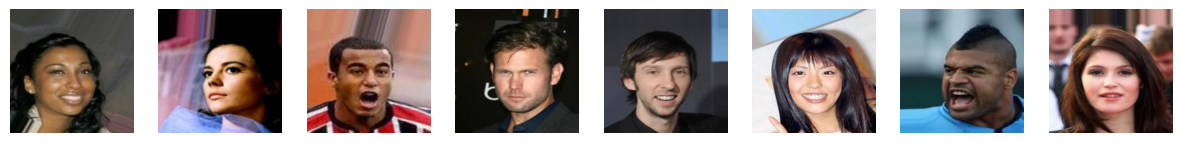

Noisy Train Images:


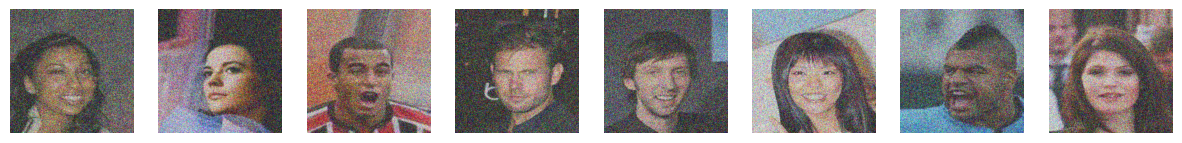




Clean Validation Images:


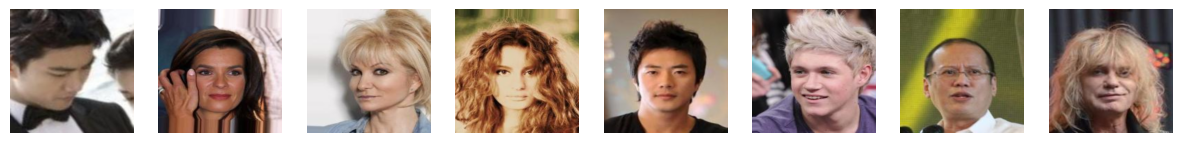

Noisy Validation Images:


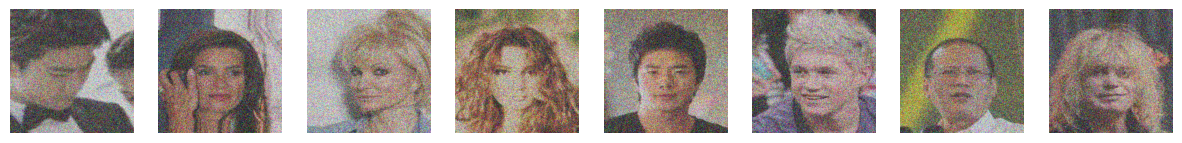

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataloader, num_images=8):
    # Get a batch of images
    for i, (images, _) in enumerate(dataloader):
        # Display images from the batch
        plt.figure(figsize=(15, 5))
        for j in range(num_images):
            plt.subplot(1, num_images, j + 1)
            image = images[j].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and permute dimensions
            plt.imshow(image)
            plt.axis('off')
        plt.show()
        break 
        
        
print("Clean Train Images:")
show_images(celeb_train_dataloader)

# print("Blurry Train Images:")
# show_images(celeb_blurry_train_dataloader)

print("Noisy Train Images:")
show_images(celeb_noisy_train_dataloader)





print("\n\n\nClean Validation Images:")
show_images(celeb_val_dataloader)

# print("Blurry Validation Images:")
# show_images(celeb_blurry_val_dataloader)

print("Noisy Validation Images:")
show_images(celeb_noisy_val_dataloader)

# **Convolutional AutoEncoder Architecture**

---
## **Convolutional Variational Autoencoder (v3)** 
### 5 layers in encoder network
### 5 layers in decoder network
---

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE_v3(nn.Module):
    def __init__(self, img_channels=3, z_dim=256, img_size=64):
        super(CVAE_v3, self).__init__()
        self.img_size = img_size

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.enc_conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.enc_conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.enc_conv4 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.enc_conv5 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=4,
            stride=2,
            padding=1
        )

        # Determine the size of the output of the last convolutional layer
        conv_out_size = self.calculate_conv_output_size(img_size)

        self.enc_fc_mu = nn.Linear(512 * conv_out_size * conv_out_size, z_dim)
        self.enc_fc_logvar = nn.Linear(512 * conv_out_size * conv_out_size, z_dim)

        # Decoder layers
        self.dec_fc = nn.Linear(z_dim, 512 * conv_out_size * conv_out_size)
        self.dec_conv1 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_conv2 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_conv3 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_conv4 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_conv5 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=img_channels,
            kernel_size=4,
            stride=2,
            padding=1
        )

    def calculate_conv_output_size(self, img_size):
        # Calculate the output size after passing through the convolutional layers
        out_size = img_size
        for _ in range(5):  # 5 convolutional layers in encoder and decoder
            out_size = (out_size + 2 - 4) // 2 + 1  # Assuming kernel_size=4, stride=2, padding=1
        return out_size

    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = F.relu(self.enc_conv4(x))
        x = F.relu(self.enc_conv5(x))
        x = x.view(-1, 512 * self.calculate_conv_output_size(self.img_size) * self.calculate_conv_output_size(self.img_size))  # Flatten
        mu = self.enc_fc_mu(x)
        logvar = self.enc_fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decoder(self, z):
        x = self.dec_fc(z)
        x = x.view(-1, 512, self.calculate_conv_output_size(self.img_size), self.calculate_conv_output_size(self.img_size))  # Reshape
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = F.relu(self.dec_conv3(x))
        x = F.relu(self.dec_conv4(x))
        x = torch.sigmoid(self.dec_conv5(x))
        return x

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_image = self.decoder(z)
        return reconstructed_image, mu, logvar


---
# **Model Summary**
---

In [17]:
from torchinfo import summary

model_CVAE_v3 = CVAE_v3(img_size=512).to(DEVICE)
summary(model_CVAE_v3, input_size=[BATCH_SIZE, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
CVAE_v3                                  [16, 3, 512, 512]         --
├─Conv2d: 1-1                            [16, 32, 256, 256]        1,568
├─Conv2d: 1-2                            [16, 64, 128, 128]        32,832
├─Conv2d: 1-3                            [16, 128, 64, 64]         131,200
├─Conv2d: 1-4                            [16, 256, 32, 32]         524,544
├─Conv2d: 1-5                            [16, 512, 16, 16]         2,097,664
├─Linear: 1-6                            [16, 256]                 33,554,688
├─Linear: 1-7                            [16, 256]                 33,554,688
├─Linear: 1-8                            [16, 131072]              33,685,504
├─ConvTranspose2d: 1-9                   [16, 256, 32, 32]         2,097,408
├─ConvTranspose2d: 1-10                  [16, 128, 64, 64]         524,416
├─ConvTranspose2d: 1-11                  [16, 64, 128, 128]        131,136
├─ConvTranspose2d: 1

In [16]:
model_CVAE_v3

CVAE_v3(
  (enc_conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_fc_mu): Linear(in_features=131072, out_features=256, bias=True)
  (enc_fc_logvar): Linear(in_features=131072, out_features=256, bias=True)
  (dec_fc): Linear(in_features=256, out_features=131072, bias=True)
  (dec_conv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (

---
## **Loss function**
---

In [37]:
def loss_function(recon_img, input_img, mu, logvar, beta=1.0):
#     print(f"input img size = {input_img.shape}")
#     print(f"reconstructed img size = {recon_img.shape}")
    input_img = input_img.view(recon_img.size())
#     print(f"after view input img size = {input_img.shape}")
    
    BCE = nn.functional.binary_cross_entropy(
        recon_img, input_img, reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + beta * KLD


In [38]:
# set random seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

---
## **Utility functions for training**
- `train_step()` for training model
- `test_step()` for validation model
- `train()` combines training and validating utilities 
---

In [39]:
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               clean_train_dataloader: torch.utils.data.DataLoader,
               noisy_train_dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer, 
               device: torch.device,
               loss_fn = loss_function
              ):
    loss_history = []
    train_loss = 0
    num = 1
    
    # 1. model 
    model.train()
    total_loss = 0.0
    for (clean_img, _), (noisy_img, _) in zip(clean_train_dataloader, noisy_train_dataloader):
        clean_img, noisy_img = clean_img.to(DEVICE), noisy_img.to(DEVICE)

        # 2. forward pass 
        recon_img, mu, logVar = model(noisy_img)

        if num % 100 == 0:
            print(f"{num}, ", end="")
        num += 1

        # 3. calculate the loss
        loss = loss_fn(recon_img=recon_img, 
                       input_img=clean_img, 
                       mu=mu, 
                       logvar=logVar)

        # 4. optimizer zero grad 
        optimizer.zero_grad()

        # 5. loss backward 
        loss.backward()
        
        ### accumulating the training loss
        train_loss += loss.item()

        # 6. optimizer step 
        optimizer.step()
        
        average_loss = total_loss / len(clean_train_dataloader.dataset)
    train_loss = train_loss / len(clean_train_dataloader.dataset)
    loss_history.append(average_loss)
    

    return train_loss

In [41]:
def test_step(model: torch.nn.Module,
             clean_test_dataloader: torch.utils.data.DataLoader,
             noisy_test_dataloader: torch.utils.data.DataLoader,
             loss_fn,
             device: torch.device):
  ### TESTING
  test_loss = 0


  # Put the model into eval mode
  model.eval()

  # turn on inference mode
  with torch.inference_mode():
#     for X, y in data_loader:
    for (clean_test_img, _), (noisy_test_img, _) in zip(clean_test_dataloader, noisy_test_dataloader):
        # put the data X and y into  device
        clean_test_img, noisy_test_img = clean_test_img.to(device), noisy_test_img.to(device)

        # 1. forward pass (outputs raw logits )
        reconstructed_test_img, mu, logVar = model(noisy_test_img)

        # 2. calculate  the loss (accumulatively)
        loss = loss_fn(recon_img=reconstructed_test_img, input_img=clean_test_img, mu=mu, logvar=logVar)
#         loss = loss_fn(reconstructed_test_img, clean_test_img)
        test_loss += loss.item()

        # 3. calculate accuracy
#         test_pred_labels = test_pred_logits.argmax(dim=1)
#         test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)      # go from raw logits -> prediction labels

    # calculate the test loss and average per batc/h
    test_loss /= len(clean_test_dataloader.dataset)

    # calculate the test accuracy average per batch
#     test_acc /= len(data_loader)

  # print what's happening
  # print(f"\nTest loss: {train_loss:.4f}, Test accuracy: {test_acc:.4f}% \n")
    return test_loss

In [42]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          clean_train_dataloader: torch.utils.data.DataLoader,
          noisy_train_dataloader: torch.utils.data.DataLoader,
          clean_val_dataloader: torch.utils.data.DataLoader,
          noisy_val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler,
          loss_fn,
          epochs: int,
          device : torch.device = DEVICE):
    results = {"train_loss": [],
#             "train_acc": [],
            "test_loss": [],
#             "test_acc": []
              }
    best_val_loss = float('inf')  # Initialize with a very high value
    consecutive_same_loss_count = 0
    prev_loss = None

    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model = model,
                            clean_train_dataloader = clean_train_dataloader,
                            noisy_train_dataloader = noisy_train_dataloader,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            device = DEVICE
                           )
        if (epoch + 1) % 40 == 0 and epoch != 0:
            model_state_dict = model.state_dict()
            save_path = f"./models/{model.__class__.__name__}/model_{epoch}epoch_trained.pth"

            # Create the directory if it doesn't exist
            os.makedirs(os.path.dirname(save_path), exist_ok=True)

            # Save the model state dictionary to the specified path
            torch.save(model_state_dict, save_path)

      
        test_loss = test_step(model = model,
                              clean_test_dataloader = clean_val_dataloader,
                              noisy_test_dataloader = noisy_val_dataloader,
                              loss_fn = loss_fn,
                              device = DEVICE)

        # Update learning rate
#         scheduler.step()

        # Save the model if the validation loss is improved
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            model_state_dict = model.state_dict()
            save_path = f"./models/{model.__class__.__name__}/best_model.pth"
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(model_state_dict, save_path)

        print(f"Epoch: {epoch + 1} | Train loss : {train_loss:.4f} | Test Loss: {test_loss:.4f}")
        results["train_loss"].append(train_loss)
    #     results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
    #     results["test_acc"].append(test_acc)

        
        # Check if the current epoch has the same loss as the previous epoch
        if prev_loss is not None and train_loss == prev_loss:
            consecutive_same_loss_count += 1
        else:
            consecutive_same_loss_count = 0

        prev_loss = train_loss

        # If there are 4 consecutive epochs with the same loss, break out of the loop
        if consecutive_same_loss_count == 4:
            print("Training halted due to 4 consecutive epochs with the same loss.")
            break

    return results

---

### **Loads the `state_dict` of from `*.pth` file if passed as argument and starts training the model**

---

In [43]:
def train_model(model, epochs, optimizer, state_dict_file=None):
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    if state_dict_file:
        print(f"{state_dict_file} present!!!")
        state_dict = torch.load(state_dict_file)
        # If the model was trained using DataParallel, you need to remove the 'module.' prefix
        # from all keys in the state_dict
        if next(iter(state_dict.keys())).startswith("module"):
            state_dict = {key[7:]: value for key, value in state_dict.items()}

            # Load the state_dict into the model
            model.load_state_dict(state_dict)

#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=PATIENCE, verbose=True
    )



    model_loss_results = train(model = model, 
                                clean_train_dataloader = celeb_train_dataloader, 
                                noisy_train_dataloader = celeb_noisy_train_dataloader, 
                                clean_val_dataloader = celeb_val_dataloader, 
                                noisy_val_dataloader = celeb_noisy_val_dataloader,
                                optimizer = optimizer,
                                scheduler = scheduler,
                                loss_fn = loss_function, 
                                epochs = epochs, 
                                device = DEVICE
                               )
    return model_loss_results

In [ ]:
model_CVAE_v3 = CVAE_v3(img_size=IMAGE_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model_CVAE_v3.parameters(), lr=LR)          # lr = alpha {learning rate}

# def train_model(model, epochs, optimizer, state_dict_file=None):
model_CVAE_v3_result = train_model(model=model_CVAE_v3, 
                                   epochs=EPOCHS, 
                                   optimizer=optimizer, 
#                                    state_dict_file="./models/CVAE_v1/best_model.pth"
                                  )

  0%|          | 0/200 [00:00<?, ?it/s]

100, 200, 300, 400, 500, Epoch: 1 | Train loss : 438907.8889 | Test Loss: 411068.0743
100, 200, 300, 400, 500, Epoch: 2 | Train loss : 406401.5075 | Test Loss: 403827.4722
100, 200, 300, 400, 500, Epoch: 3 | Train loss : 401066.4996 | Test Loss: 401113.0203
100, 200, 300, 400, 500, Epoch: 4 | Train loss : 397965.0221 | Test Loss: 398369.4753
100, 200, 300, 400, 500, Epoch: 5 | Train loss : 396440.3280 | Test Loss: 396659.7027
100, 200, 300, 400, 500, Epoch: 6 | Train loss : 395248.0259 | Test Loss: 395522.6675
100, 200, 300, 400, 500, Epoch: 7 | Train loss : 393599.6349 | Test Loss: 393660.9420
100, 200, 300, 400, 500, Epoch: 8 | Train loss : 390373.4369 | Test Loss: 392377.1115
100, 200, 300, 400, 500, Epoch: 9 | Train loss : 388882.3041 | Test Loss: 391668.7070
100, 200, 300, 400, 500, Epoch: 10 | Train loss : 388198.1711 | Test Loss: 391998.0975
100, 200, 300, 400, 500, Epoch: 11 | Train loss : 387273.6084 | Test Loss: 390019.5175
100, 200, 300, 400, 500, Epoch: 12 | Train loss : 38

---

## **Model's loss value : `train_loss` and `test_loss`**
---

In [1]:
model_CVAE_v3_result

{'train_loss': [438907.8889375,
  406401.5075,
  401066.4995625,
  397965.0220625,
  396440.328,
  395248.025875,
  393599.634875,
  390373.4369375,
  388882.3040625,
  388198.171125,
  387273.6084375,
  386264.440125,
  386091.110125,
  385886.4225625,
  384762.82025,
  383550.18125,
  382969.1076875,
  382999.9243125,
  384022.71525,
  384030.9493125,
  383040.80325,
  382892.43275,
  382846.513875,
  382201.694375,
  381649.4675,
  382587.3569375,
  382405.6203125,
  381817.9139375,
  381445.5570625,
  381819.0974375,
  381492.3733125,
  380982.488,
  380510.5435625,
  380527.9568125,
  380954.8625625,
  382522.2256875,
  382369.9638125,
  381034.36275,
  379925.7288125,
  379386.6540625,
  379207.9811875,
  380037.34475,
  382395.444625,
  381871.9286875,
  380453.254125,
  379811.9749375,
  379803.026375,
  380621.5979375,
  381928.61275,
  381474.378625,
  380277.9985,
  379829.444,
  380144.86775,
  381377.9800625,
  381650.488875,
  380568.6425,
  379842.9335625,
  379364.20687

In [2]:
model_CVAE_v3_result  = {'train_loss': [438907.8889375,
  406401.5075,
  401066.4995625,
  397965.0220625,
  396440.328,
  395248.025875,
  393599.634875,
  390373.4369375,
  388882.3040625,
  388198.171125,
  387273.6084375,
  386264.440125,
  386091.110125,
  385886.4225625,
  384762.82025,
  383550.18125,
  382969.1076875,
  382999.9243125,
  384022.71525,
  384030.9493125,
  383040.80325,
  382892.43275,
  382846.513875,
  382201.694375,
  381649.4675,
  382587.3569375,
  382405.6203125,
  381817.9139375,
  381445.5570625,
  381819.0974375,
  381492.3733125,
  380982.488,
  380510.5435625,
  380527.9568125,
  380954.8625625,
  382522.2256875,
  382369.9638125,
  381034.36275,
  379925.7288125,
  379386.6540625,
  379207.9811875,
  380037.34475,
  382395.444625,
  381871.9286875,
  380453.254125,
  379811.9749375,
  379803.026375,
  380621.5979375,
  381928.61275,
  381474.378625,
  380277.9985,
  379829.444,
  380144.86775,
  381377.9800625,
  381650.488875,
  380568.6425,
  379842.9335625,
  379364.206875,
  379288.60125,
  379845.391625,
  381001.5389375,
  381729.3680625,
  381281.71125,
  380195.446125,
  379099.7481875,
  378638.2888125,
  378844.524625,
  379944.9475,
  381498.0196875,
  382046.3901875,
  381104.389375,
  380111.99325,
  379537.4283125,
  378937.0529375,
  378698.0453125,
  378643.71175,
  379110.9495,
  379988.19025,
  381172.43,
  382350.5925,
  382145.2140625,
  381147.116,
  380223.160625,
  379043.65,
  378400.5570625,
  378069.5409375,
  378188.587,
  378839.2549375,
  379780.2053125,
  380614.6031875,
  381220.381875,
  381955.3198125,
  381394.6439375,
  380550.707875,
  379862.5781875,
  379425.3725,
  379247.6195,
  379220.7359375,
  379415.1713125,
  379728.597375,
  380357.485125,
  380883.3005,
  381139.0854375,
  380797.5798125,
  380213.7128125,
  379531.3943125,
  379092.7936875,
  378913.1851875,
  378953.8520625,
  379164.6281875,
  380045.520375,
  381013.016375,
  380981.5775625,
  380262.0031875,
  379337.433125,
  378783.442,
  378377.1224375,
  378154.9035625,
  378151.9209375,
  378522.391,
  379257.1174375,
  380045.532875,
  380403.2193125,
  380546.35875,
  380445.69325,
  380037.8314375,
  379531.86825,
  379152.538,
  379130.0385625,
  378943.43975,
  378812.243,
  378731.57525,
  378935.370375,
  379191.493375,
  379584.3938125,
  380077.0749375,
  380627.7464375,
  380794.38525,
  380120.2281875,
  379478.7923125,
  378836.4875,
  378282.6045625,
  377791.509375,
  377567.2395,
  377686.10025,
  378177.0135,
  378696.009625,
  379007.9825625,
  379212.71725,
  379091.86325,
  378920.9165625,
  379128.206375,
  379769.250875,
  380268.6039375,
  380502.036375,
  380082.4893125,
  379195.32125,
  378534.0938125,
  378112.9794375,
  377831.9994375,
  377681.4243125,
  377658.07925,
  377879.0270625,
  378434.5174375,
  379136.650625,
  379212.773125,
  379098.7561875,
  379110.7093125,
  379147.637625,
  378981.4578125,
  378560.0736875,
  378054.1489375,
  377752.7966875,
  377811.1890625,
  378099.2075,
  378251.022125,
  378260.1516875,
  378307.56075,
  378391.179625,
  378500.089,
  378676.090875,
  378959.5389375,
  379248.253625,
  379046.22975,
  378519.3210625,
  377935.0126875,
  377606.2698125,
  377678.8344375,
  378076.3450625,
  378326.8298125,
  378217.0640625,
  378304.9188125,
  378411.7150625,
  378358.2269375,
  378347.517625,
  378338.973875,
  378156.1671875,
  377896.7635,
  377854.0090625,
  377934.1444375],
 'test_loss': [411068.07425,
  403827.47225,
  401113.02025,
  398369.47525,
  396659.70275,
  395522.6675,
  393660.942,
  392377.1115,
  391668.707,
  391998.0975,
  390019.5175,
  389973.3545,
  389935.791,
  389693.66775,
  391022.916,
  390802.8265,
  390727.46475,
  390102.2195,
  390909.17875,
  389445.83575,
  389542.83425,
  391703.95325,
  390718.05675,
  390397.99925,
  391588.274,
  390563.2795,
  390849.399,
  390411.108,
  391623.941,
  390736.81175,
  390634.27425,
  390308.04075,
  390405.7175,
  392268.09675,
  393662.10125,
  400006.24475,
  397660.28925,
  393764.84175,
  392298.09475,
  390648.57725,
  390790.5025,
  395838.0245,
  394508.854,
  392015.91175,
  392114.5645,
  394065.1465,
  395510.29875,
  394842.68675,
  395611.85175,
  393662.19325,
  393288.44425,
  395482.33725,
  398065.74025,
  395844.985,
  394405.64875,
  394805.9975,
  394338.608,
  394653.44375,
  394578.60625,
  395822.97575,
  397880.48,
  396607.32925,
  396744.21075,
  397002.2185,
  395951.412,
  394657.297,
  394576.84075,
  396832.307,
  399111.39175,
  403348.873,
  402469.8855,
  403524.615,
  400575.50825,
  401973.49225,
  401173.009,
  402087.22075,
  402248.08975,
  402202.34675,
  401565.79775,
  399407.133,
  400895.3765,
  403814.28725,
  402896.039,
  402464.66325,
  402552.64125,
  404510.4725,
  405024.90425,
  403294.7175,
  400601.414,
  399034.448,
  399702.1435,
  403307.298,
  408394.63725,
  402639.8955,
  399641.74825,
  399784.81125,
  401016.90225,
  401238.692,
  402454.7775,
  405627.19125,
  405047.78325,
  405869.81075,
  404119.197,
  407668.59025,
  407899.4385,
  406044.547,
  401064.16125,
  400494.50775,
  400529.686,
  401002.33075,
  402922.441,
  402721.80775,
  404437.10475,
  404407.516,
  403107.576,
  402920.908,
  402653.22775,
  401047.56675,
  401756.49175,
  401782.137,
  401302.55275,
  401603.84325,
  401998.3425,
  403194.2505,
  402653.5625,
  404213.6685,
  408604.04775,
  416954.6245,
  420701.18275,
  416592.543,
  415378.57875,
  407952.64125,
  404864.949,
  404405.42325,
  406726.98625,
  404485.043,
  407570.75075,
  412919.673,
  411852.81425,
  408250.464,
  404072.46825,
  403118.8125,
  403546.23125,
  405383.89475,
  406112.5595,
  406019.25375,
  405913.88375,
  409147.792,
  412697.763,
  413749.6525,
  416533.76225,
  423149.06675,
  426589.81925,
  415259.66425,
  408104.535,
  407384.00125,
  405889.7075,
  404753.289,
  403721.35025,
  404007.91075,
  404677.346,
  405691.87875,
  405636.182,
  405426.3795,
  406694.0065,
  408309.459,
  411059.4125,
  411108.86875,
  411733.81275,
  413832.9505,
  412853.298,
  407039.051,
  405530.0375,
  406721.0145,
  408324.2735,
  409810.632,
  416841.69425,
  415705.7675,
  410488.778,
  409506.55275,
  409251.2065,
  409233.72825,
  408309.4545,
  406374.82775,
  406201.4715,
  405983.35275,
  407693.15025,
  412042.5805,
  416149.67,
  414325.56,
  410937.22225,
  408954.59725,
  410890.0525,
  411717.01375,
  410237.206,
  408935.465,
  408806.01075,
  408252.46975,
  408340.275,
  407859.39625]}


---
## **Plotting loss graph**

loss graph includes `train_loss` and `test_loss`

---

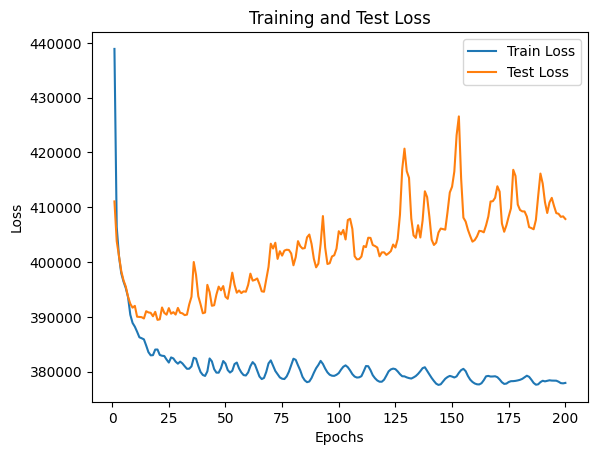

In [5]:
import matplotlib.pyplot as plt

def plot_loss(data, total_epochs):
    # Generate epochs list using total_epochs
    epochs = range(1, total_epochs + 1)
    train_loss = data["train_loss"]
    test_loss = data["test_loss"]

    # Plot train_loss and test_loss
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

plot_loss(model_CVAE_v3_result, EPOCHS)

---
# **Testing our best model for `CVAE_v3` architecture**

model state_dict is stored is `./models/CVAE_v3/best_model.pth`

---

In [22]:
def load_and_return_model(model_path, CVAE_arch):
    model = CVAE_arch(img_size=IMAGE_SIZE).to(DEVICE)

    state_dict = torch.load(model_path)
    print(type(state_dict))

    # If the model was trained using DataParallel, the 'module.' prefix need to be removed
    # from all keys in the state_dict
    if next(iter(state_dict.keys())).startswith("module"):
        state_dict = {key[7:]: value for key, value in state_dict.items()}

    # Load the state_dict into the model
    model.load_state_dict(state_dict)
    return model


<class 'collections.OrderedDict'>


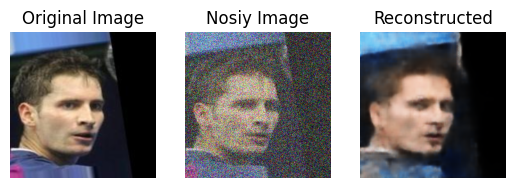

In [23]:
index = 99

original_image = celeb_val_dataloader.dataset[index][0]

nosiy_image = celeb_noisy_val_dataloader.dataset[index][0]

model = load_and_return_model("./models/CVAE_v3/best_model.pth", CVAE_v3)
model.eval()
with torch.inference_mode():
    reconstructed_image, _, _ = model(nosiy_image.unsqueeze(0).to(DEVICE))


plt.subplot(1, 3, 1)
plt.imshow(original_image.permute(1,2,0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(nosiy_image.permute(1,2,0))
plt.title('Nosiy Image')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image.squeeze().cpu().permute(1,2,0))
plt.title('Reconstructed')
plt.axis('off')


plt.show()

data/asd.png already exists, skipping download...
<class 'collections.OrderedDict'>


/tmp/ipykernel_34/860573754.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


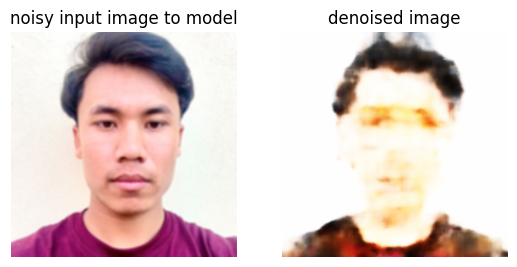

In [58]:
import torchvision.transforms.functional as TF


import requests 
from pathlib import Path
image_path =Path("./data/asd.png")

# download image if it does not exits
if not image_path.is_file():
    with open(image_path, "wb") as f:
        request = requests.get("https://files.saurabtharu.com.np/nihang.jpg")
        print(f"Downloading {image_path}")
        f.write(request.content)
        
else:
    print(f"{image_path} already exists, skipping download...")
    
    
import torchvision
image = torchvision.io.read_image(str(image_path))

image_1 = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.

# image_1 = add_noise_to_image(image_1,0.6)


plt.imshow(image_1.permute(1,2,0))

image_pil = TF.to_pil_image(image_1)

transformed_image = transform(image_pil)

model = load_and_return_model("./models/CVAE_v3/best_model.pth", CVAE_v3)
model.eval()
with torch.inference_mode():
    denoised, _, _ = model(transformed_image.unsqueeze(0).to(DEVICE))

plt.subplot(1,2,1)
plt.title("noisy input image to model")
plt.imshow(transformed_image.squeeze(0).cpu().permute(1,2,0))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("denoised image")
plt.imshow(denoised.squeeze(0).cpu().permute(1,2,0))
plt.axis('off')
plt.show()

data/asd.png already exists, skipping download...
<class 'collections.OrderedDict'>

Shape of transformed image : torch.Size([3, 512, 512])
Shape of denoised image    : torch.Size([1, 3, 512, 512])



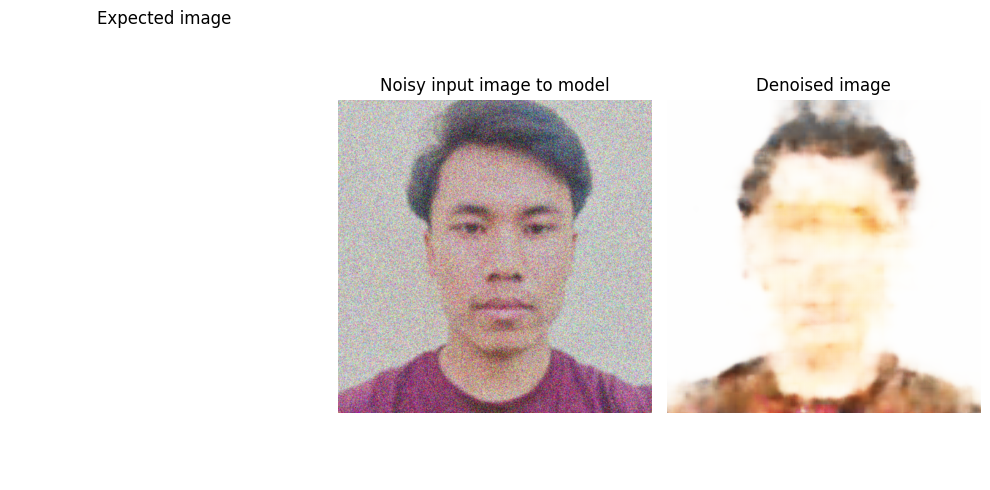

In [85]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torchvision
import requests 
from pathlib import Path

# Define the image path
image_path = Path("./data/asd.png")

# Download image if it does not exist
if not image_path.is_file():
    with open(image_path, "wb") as f:
        request = requests.get("https://files.saurabtharu.com.np/nihang.jpg")
        print(f"Downloading {image_path}")
        f.write(request.content)
else:
    print(f"{image_path} already exists, skipping download...")

# Read and preprocess the image
image_1 = torchvision.io.read_image(str(image_path))
image_pil = TF.to_pil_image(image_1)

# Apply necessary transformation here if needed
transformed_image = transform(noisy_image_pil)

# original_image = celeb_train_dataloader.dataset[99][0]
# noisy_image = celeb_noisy_train_dataloader.dataset[99][0]


model = load_and_return_model("./models/CVAE_v3/best_model.pth", CVAE_v3)
model.eval()
with torch.no_grad():
    # Pass the image through the model
    denoised, _, _ = model(transformed_image.unsqueeze(0).to(DEVICE))

# print(f"""
# Shape of original image : {original_image.shape}
# Shape of noisy image    : {noisy_image.shape}
# Shape of denosed image  : {denoised.shape}
# """)


print(f"""
Shape of transformed image : {transformed_image.shape}
Shape of denoised image    : {denoised.shape}
""")

# Display the original and denoised images
plt.figure(figsize=(10, 5))

# Plot the original noisy input image
plt.subplot(1, 3, 1)
plt.title("Expected image ")
# plt.imshow(original_image.squeeze().permute(1, 2, 0))
plt.axis('off')



plt.subplot(1, 3, 2)
plt.title("Noisy input image to model")
plt.imshow(transformed_image.permute(1, 2, 0))
plt.axis('off')

# Plot the denoised image
plt.subplot(1, 3, 3)
plt.title("Denoised image")
plt.imshow(denoised.squeeze().permute(1, 2, 0).cpu().numpy())
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# import torch
# import matplotlib.pyplot as plt

# def test_model(
#                     state_dict_file,
#                 celeb_val_dataloader = celeb_val_dataloader,
#                 celeb_noisy_val_dataloader = celeb_noisy_val_dataloader
#               ):
#     model = CVAE(img_size=IMAGE_SIZE).to(DEVICE)

#     # Load the state_dict
#     state_dict = torch.load(state_dict_file)
#     print(type(state_dict))

#     # If the model was trained using DataParallel, you need to remove the 'module.' prefix
#     # from all keys in the state_dict
#     if next(iter(state_dict.keys())).startswith("module"):
#         state_dict = {key[7:]: value for key, value in state_dict.items()}

#     # Load the state_dict into the model
#     model.load_state_dict(state_dict)
# #     print(f"type of model : {type(model)}")
    

#     index = 20

#     original_image = celeb_val_dataloader.dataset[index][0]

#     nosiy_image = celeb_noisy_val_dataloader.dataset[index][0]
#     model.eval()
#     with torch.inference_mode():
#         reconstructed_image, _, _ = model(nosiy_image.unsqueeze(0).to(DEVICE))


#     plt.subplot(1, 3, 1)
#     plt.imshow(original_image.permute(1, 2, 0))
#     plt.title("Original Image")
#     plt.axis("off")

#     plt.subplot(1, 3, 2)
#     plt.imshow(nosiy_image.permute(1, 2, 0))
#     plt.title("Nosiy Image")
#     plt.axis("off")


#     plt.subplot(1, 3, 3)
#     plt.imshow(reconstructed_image.squeeze().cpu().permute(1, 2, 0))
#     plt.title("Reconstructed")
#     plt.axis("off")

#     plt.show()
    
# test_model("./models/parallel_model_50epoch_trained.pth", celeb_val_dataloader, celeb_noisy_val_dataloader)

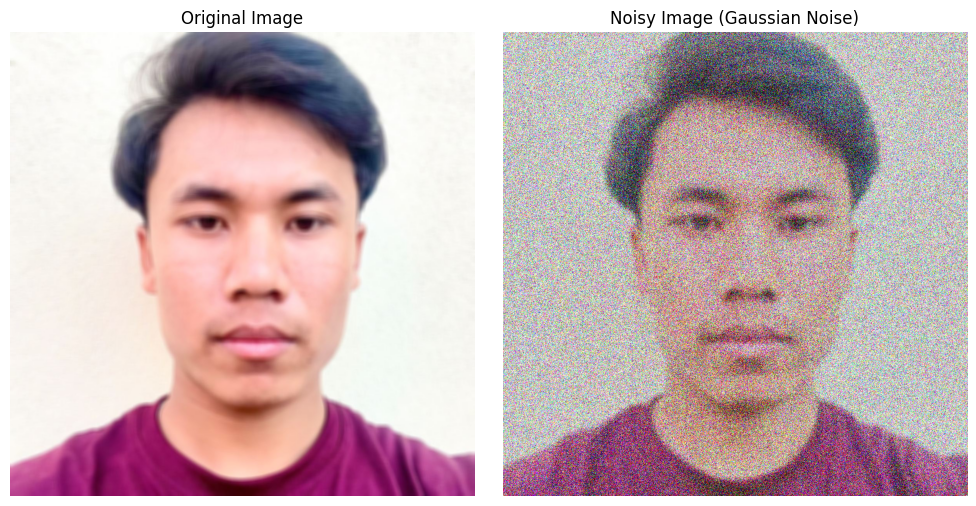

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torchvision
import requests
from PIL import Image
from pathlib import Path

# Define the image path
image_path = Path("./data/nihang.jpg")

# Download image if it does not exist
if not image_path.is_file():
    with open(image_path, "wb") as f:
        request = requests.get("https://files.saurabtharu.com.np/nihang.jpg")
        print(f"Downloading {image_path}")
        f.write(request.content)
else:
    print(f"{image_path} already exists, skipping download...")

# Read the image
image = Image.open(image_path)

# Convert to tensor
image_tensor = TF.to_tensor(image)

# Add Gaussian noise
noisy_image = image_tensor + 0.6 * torch.randn_like(image_tensor)

# Clip pixel values to range [0, 1]
noisy_image = torch.clamp(noisy_image, 0, 1)

# Convert back to PIL Image
noisy_image_pil = TF.to_pil_image(noisy_image)

# Display the original and noisy images
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

# Plot the noisy image
plt.subplot(1, 2, 2)
plt.title("Noisy Image (Gaussian Noise)")
plt.imshow(noisy_image_pil)
plt.axis('off')

plt.tight_layout()
plt.show()
